In [1]:
import pandas as pd

# Load data
filename = "mens_all_time_2019.csv"
df_combined = pd.read_csv(filename)
print(f"{df_combined.shape[0]} fragrances loaded from {filename}")

656 fragrances loaded from mens_all_time_2019.csv


In [2]:
# View fragrances with either zero upvotes or zero downvotes
df_combined[(df_combined["upvotes"] == 0) | (df_combined["downvotes"] == 0)]

,name,link,upvotes,downvotes,year,order
386,Tea for Two L'Artisan Parfumeur (unisex) ~ 2000,https://www.fragrantica.com/perfume/L-Artisan-...,4,0,2000,387
407,Patchouli Intense Nicolai Parfumeur Createur (...,https://www.fragrantica.com/perfume/Nicolai-Pa...,3,0,0,408
408,Nemo Cacharel (male) ~ 2000,https://www.fragrantica.com/perfume/Cacharel/N...,3,0,2000,409
409,Fou d'Absinthe L'Artisan Parfumeur (unisex) ~ ...,https://www.fragrantica.com/perfume/L-Artisan-...,3,0,2006,410
453,Montana Parfum d'Homme Montana (male) ~ 1989,https://www.fragrantica.com/perfume/Montana/Mo...,2,0,1989,454
455,Cuir Ottoman Parfum d'Empire (unisex) ~ 2006,https://www.fragrantica.com/perfume/Parfum-d-E...,2,0,2006,456
530,Esencia pour Homme Loewe (male) ~ 1988,https://www.fragrantica.com/perfume/Loewe/Esen...,1,0,1988,531
601,Homme Carven (male) ~ 1999,https://www.fragrantica.com/perfume/Carven/Hom...,0,1,1999,602


In [3]:
# Filter out fragrances with either zero upvotes or zero downvotes
df_combined = df_combined[
    (df_combined["upvotes"] != 0) & (df_combined["downvotes"] != 0)
]

In [4]:
# Add column for total votes
df_combined["total_votes"] = df_combined["upvotes"] + df_combined["downvotes"]

# Limit data to top quartile of total votes
# df_combined = df_combined[
#     df_combined["total_votes"] >= df_combined["total_votes"].quantile(0.75)
# ]

In [5]:
# Add feature columns
df_combined["ratio"] = df_combined["upvotes"] / df_combined["total_votes"]
df_combined["inverse_order"] = df_combined.shape[0] - df_combined["order"].rank() + 1
df_combined["bayes"] = (df_combined["upvotes"] + df_combined["upvotes"].median()) / (
    df_combined["upvotes"]
    + df_combined["upvotes"].median()
    + df_combined["downvotes"]
    + df_combined["downvotes"].median()
)

In [6]:
import numpy as np


# Define functions for curve fitting
def linear(x, m, b):
    return m * x + b


def logistic(x, L, k, d):
    return L / (1 + np.exp(-k * (x - d)))


def cubic(x, a, b, c, d):
    return a * pow(x, 3) + b * pow(x, 2) + c * x + d


def exponential(x, a, b, c, d):
    return a * pow(b, (x - c)) + d


def logarithmic(x, a, b, c):
    return a * np.log(x) + c

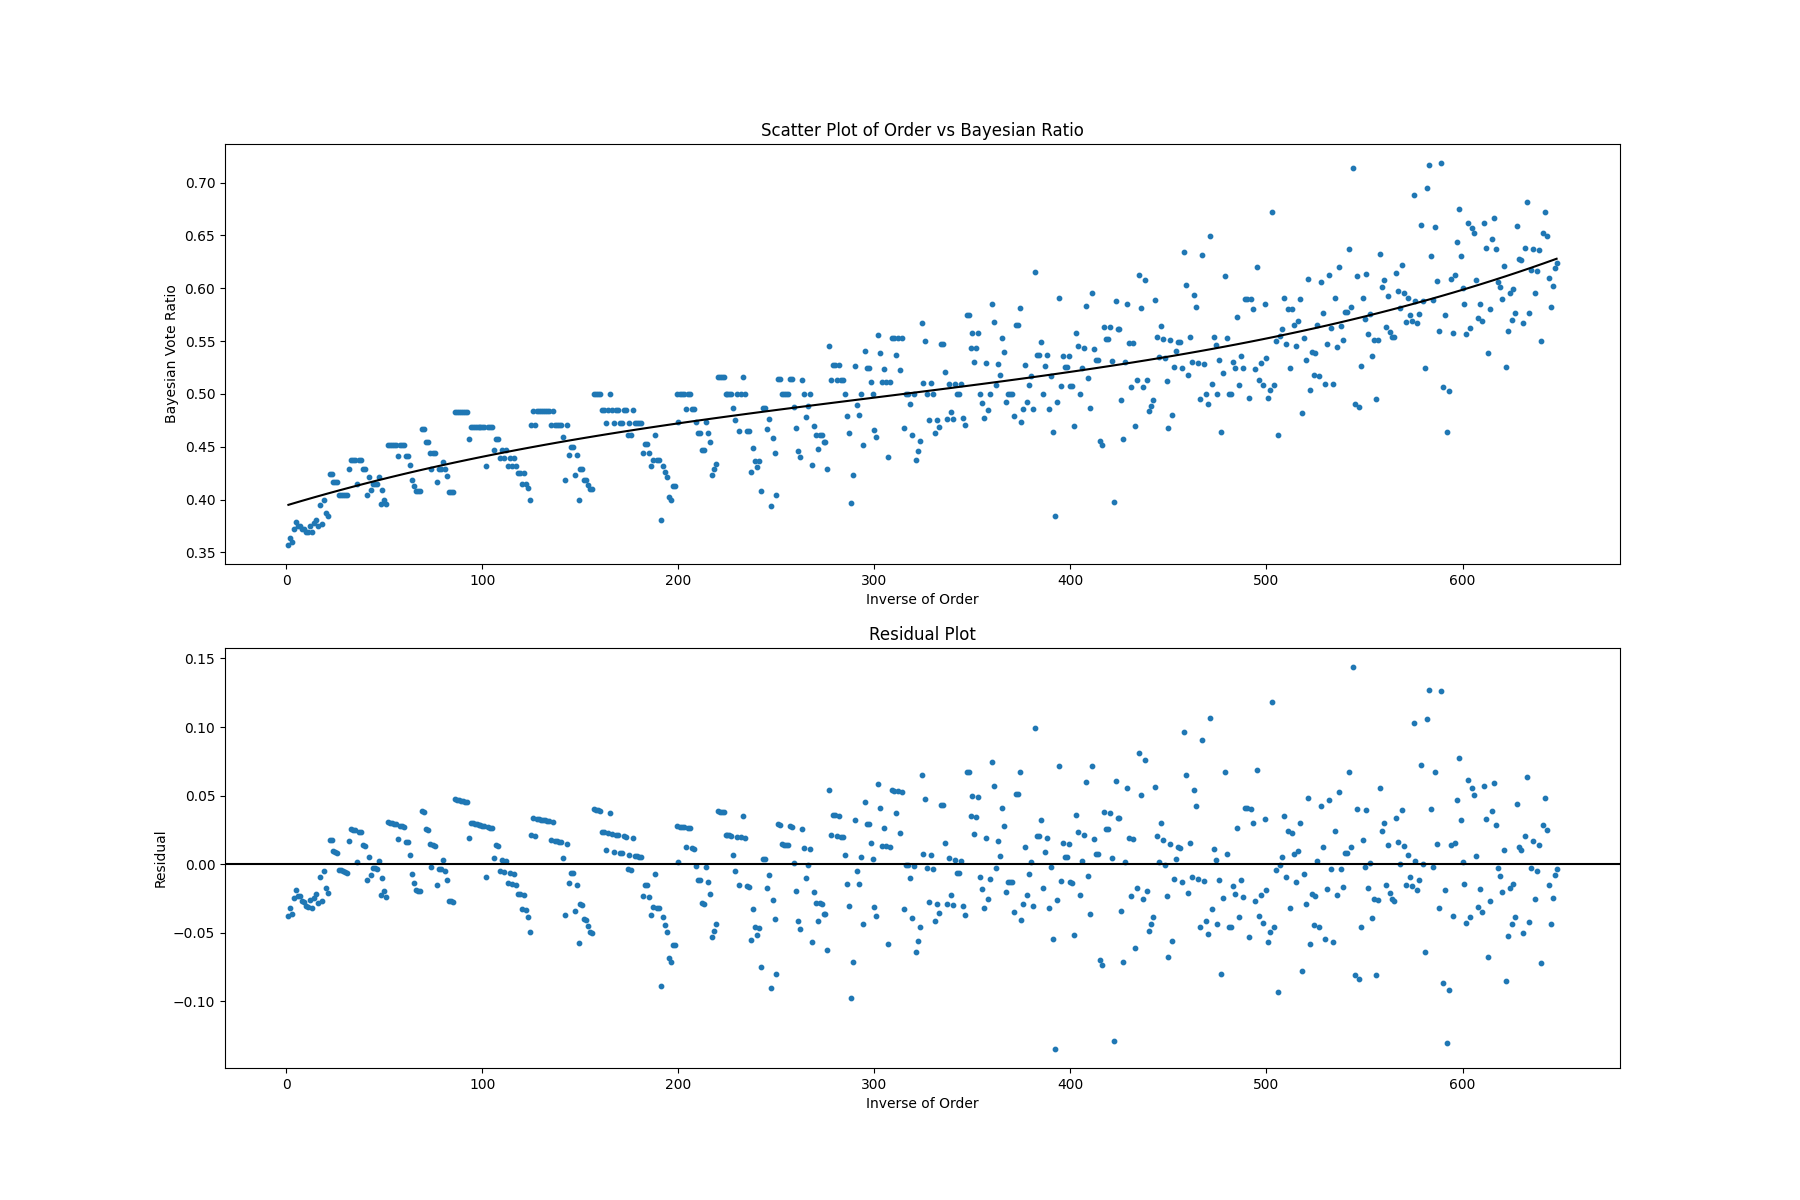

In [7]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import mplcursors

%matplotlib widget

# Make scatter plot
plt.close("all")
fig, ax = plt.subplots(2, figsize=(18, 12))
ax[0].set_title("Scatter Plot of Order vs Bayesian Ratio")
ax[0].set(xlabel="Inverse of Order")
ax[0].set(ylabel="Bayesian Vote Ratio")

# Plot x and y
y = df_combined["bayes"]
# y = y.apply(np.log)
x = df_combined["inverse_order"]
# x = x.apply(np.log)
sc1 = ax[0].scatter(x, y, s=10)

# Plot best-fit curve
fit_function = cubic
params, covariance = curve_fit(fit_function, x, y)
xhat = np.linspace(x.min(), x.max(), 100)
ax[0].plot(xhat, fit_function(xhat, *params), color="k")

# Calculate & plot residuals
df_combined["yhat"] = fit_function(x, *params)
df_combined["residual"] = y - df_combined["yhat"]
# df_combined.sort_values("residual", inplace=True)
# df_combined.reset_index(drop=True, inplace=True)
sc2 = ax[1].scatter(x, df_combined["residual"], s=10)
ax[1].axhline(color="k")
ax[1].set_title("Residual Plot")
ax[1].set(xlabel="Inverse of Order")
ax[1].set(ylabel="Residual")

# Add cursors
cursor1 = mplcursors.cursor(sc1, hover=False)
cursor2 = mplcursors.cursor(sc2, hover=False)


@cursor1.connect("add")
@cursor2.connect("add")
def on_add(sel):
    sel.annotation.set(
        text=df_combined[
            ["name", "upvotes", "downvotes", "ratio", "inverse_order", "bayes"]
        ]
        .iloc[sel.index]
        .to_string()
    )


# Show figure
plt.show()

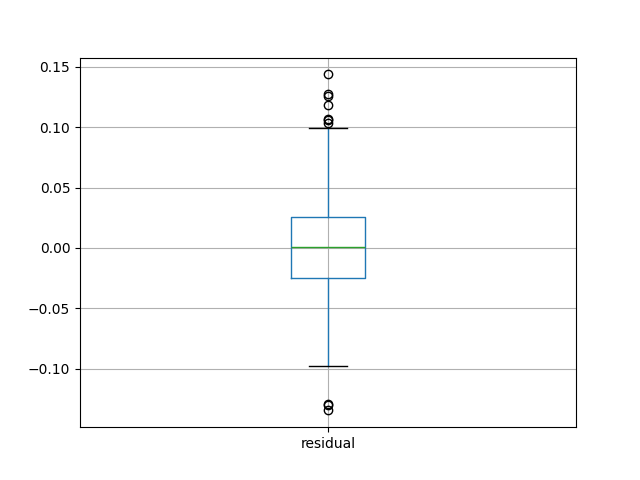

In [8]:
plt.close("all")
residual_boxplot = df_combined.boxplot("residual")

In [9]:
residual_q1 = df_combined["residual"].quantile(0.25)
residual_q3 = df_combined["residual"].quantile(0.75)
residual_iqr = residual_q3 - residual_q1

df_combined[
    (df_combined["residual"] > (residual_q3 + 1.5 * residual_iqr))
    | (df_combined["residual"] < (residual_q1 - 1.5 * residual_iqr))
].sort_values("residual")

,name,link,upvotes,downvotes,year,order,total_votes,ratio,inverse_order,bayes,yhat,residual
256,1 Million Paco Rabanne (male) ~ 2008,https://www.fragrantica.com/perfume/Paco-Raban...,70,119,2008,257,189,0.370370,392.0,0.384259,0.518818,-0.134559
56,Sauvage Dior (male) ~ 2015,https://www.fragrantica.com/perfume/Dior/Sauva...,179,208,2015,57,387,0.462532,592.0,0.463768,0.594207,-0.130439
226,Sauvage Eau de Parfum Dior (male) ~ 2018,https://www.fragrantica.com/perfume/Dior/Sauva...,65,104,2018,227,169,0.384615,422.0,0.397959,0.527015,-0.129056
73,Reflection Man Amouage (male) ~ 2006,https://www.fragrantica.com/perfume/Amouage/Re...,71,24,2006,74,95,0.747368,575.0,0.688525,0.585327,0.103198
66,Encre Noire A L'Extreme Lalique (male) ~ 2015,https://www.fragrantica.com/perfume/Lalique/En...,78,26,2015,67,104,0.750000,582.0,0.694656,0.588911,0.105745
177,Side Effect Initio Parfums Prives (unisex) ~ 2016,https://www.fragrantica.com/perfume/Initio-Par...,24,6,2016,178,30,0.800000,471.0,0.649123,0.542200,0.106923
145,Oud for Greatness Initio Parfums Prives (unise...,https://www.fragrantica.com/perfume/Initio-Par...,30,7,2018,146,37,0.810811,503.0,0.671875,0.553666,0.118209
59,A*Men Pure Malt Mugler (male) ~ 2009,https://www.fragrantica.com/perfume/Mugler/A-M...,84,24,2009,60,108,0.777778,589.0,0.718519,0.592596,0.125922
65,Vetiver Guerlain (male) ~ 2000,https://www.fragrantica.com/perfume/Guerlain/V...,78,22,2000,66,100,0.780000,583.0,0.716535,0.589432,0.127104
104,02 L'Air du Desert Marocain Tauer Perfumes (un...,https://www.fragrantica.com/perfume/Tauer-Perf...,47,10,2005,105,57,0.824561,544.0,0.714286,0.570588,0.143697


No such comm: 64d186cc177147498cbf797407655b3f


,name,link,upvotes,downvotes,year,order,total_votes,ratio,inverse_order,bayes,yhat,residual
256,1 Million Paco Rabanne (male) ~ 2008,https://www.fragrantica.com/perfume/Paco-Raban...,70,119,2008,257,189,0.370370,392.0,0.384259,0.518818,-0.134559
56,Sauvage Dior (male) ~ 2015,https://www.fragrantica.com/perfume/Dior/Sauva...,179,208,2015,57,387,0.462532,592.0,0.463768,0.594207,-0.130439
226,Sauvage Eau de Parfum Dior (male) ~ 2018,https://www.fragrantica.com/perfume/Dior/Sauva...,65,104,2018,227,169,0.384615,422.0,0.397959,0.527015,-0.129056
73,Reflection Man Amouage (male) ~ 2006,https://www.fragrantica.com/perfume/Amouage/Re...,71,24,2006,74,95,0.747368,575.0,0.688525,0.585327,0.103198
66,Encre Noire A L'Extreme Lalique (male) ~ 2015,https://www.fragrantica.com/perfume/Lalique/En...,78,26,2015,67,104,0.750000,582.0,0.694656,0.588911,0.105745
177,Side Effect Initio Parfums Prives (unisex) ~ 2016,https://www.fragrantica.com/perfume/Initio-Par...,24,6,2016,178,30,0.800000,471.0,0.649123,0.542200,0.106923
145,Oud for Greatness Initio Parfums Prives (unise...,https://www.fragrantica.com/perfume/Initio-Par...,30,7,2018,146,37,0.810811,503.0,0.671875,0.553666,0.118209
59,A*Men Pure Malt Mugler (male) ~ 2009,https://www.fragrantica.com/perfume/Mugler/A-M...,84,24,2009,60,108,0.777778,589.0,0.718519,0.592596,0.125922
65,Vetiver Guerlain (male) ~ 2000,https://www.fragrantica.com/perfume/Guerlain/V...,78,22,2000,66,100,0.780000,583.0,0.716535,0.589432,0.127104
104,02 L'Air du Desert Marocain Tauer Perfumes (un...,https://www.fragrantica.com/perfume/Tauer-Perf...,47,10,2005,105,57,0.824561,544.0,0.714286,0.570588,0.143697
